In [1]:
import os
import sys

src_dir = "/run/media/sahilsasane/Disk_1/Sahil/TMDC/test_repo/travel-agent/src"
sys.path.insert(0, src_dir)

In [2]:
from datetime import datetime
from typing import Literal

from langchain_community.tools import DuckDuckGoSearchResults, OpenWeatherMapQueryRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnableSerializable
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.managed import RemainingSteps
from langgraph.prebuilt import ToolNode
from langgraph.store.memory import InMemoryStore

from agents.llama_guard import LlamaGuard, LlamaGuardOutput, SafetyAssessment
from core import get_model, settings

In [ ]:
class AgentState(MessagesState, total=False):
    safety: LlamaGuardOutput
    remaining_steps: RemainingSteps

In [ ]:
web_search = DuckDuckGoSearchResults(name="WebSearch")
tools = [web_search]

# Add weather tool if API key is set
# Register for an API key at https://openweathermap.org/api/
if settings.OPENWEATHERMAP_API_KEY:
    wrapper = OpenWeatherMapAPIWrapper(
        openweathermap_api_key=settings.OPENWEATHERMAP_API_KEY.get_secret_value()
    )
    tools.append(OpenWeatherMapQueryRun(name="Weather", api_wrapper=wrapper))

current_date = datetime.now().strftime("%B %d, %Y")
instructions = f"""
    You are a helpful research assistant with the ability to search the web and use other tools.
    Today's date is {current_date}.

    NOTE: THE USER CAN'T SEE THE TOOL RESPONSE.

    A few things to remember:
    - Please include markdown-formatted links to any citations used in your response. Only include one
    or two citations per response unless more are needed. ONLY USE LINKS RETURNED BY THE TOOLS.
    - Use calculator tool with numexpr to answer math questions. The user does not understand numexpr,
      so for the final response, use human readable format - e.g. "300 * 200", not "(300 \\times 200)".
    """


def wrap_model(model: BaseChatModel) -> RunnableSerializable[AgentState, AIMessage]:
    bound_model = model.bind_tools(tools)
    preprocessor = RunnableLambda(
        lambda state: [SystemMessage(content=instructions)] + state["messages"],
        name="StateModifier",
    )
    return preprocessor | bound_model  # type: ignore[return-value]


def format_safety_message(safety: LlamaGuardOutput) -> AIMessage:
    content = (
        f"This conversation was flagged for unsafe content: {', '.join(safety.unsafe_categories)}"
    )
    return AIMessage(content=content)


async def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    m = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    model_runnable = wrap_model(m)
    response = await model_runnable.ainvoke(state, config)

    # Run llama guard check here to avoid returning the message if it's unsafe
    llama_guard = LlamaGuard()
    safety_output = await llama_guard.ainvoke("Agent", state["messages"] + [response])
    if safety_output.safety_assessment == SafetyAssessment.UNSAFE:
        return {"messages": [format_safety_message(safety_output)], "safety": safety_output}

    if state["remaining_steps"] < 2 and response.tool_calls:
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, need more steps to process this request.",
                )
            ]
        }
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


async def llama_guard_input(state: AgentState, config: RunnableConfig) -> AgentState:
    llama_guard = LlamaGuard()
    safety_output = await llama_guard.ainvoke("User", state["messages"])
    return {"safety": safety_output, "messages": []}


async def block_unsafe_content(state: AgentState, config: RunnableConfig) -> AgentState:
    safety: LlamaGuardOutput = state["safety"]
    return {"messages": [format_safety_message(safety)]}

In [5]:
# Define the graph
agent = StateGraph(AgentState)
agent.add_node("model", acall_model)
agent.add_node("tools", ToolNode(tools))
agent.add_node("guard_input", llama_guard_input)
agent.add_node("block_unsafe_content", block_unsafe_content)
agent.set_entry_point("guard_input")


# Check for unsafe input and block further processing if found
def check_safety(state: AgentState) -> Literal["unsafe", "safe"]:
    safety: LlamaGuardOutput = state["safety"]
    match safety.safety_assessment:
        case SafetyAssessment.UNSAFE:
            return "unsafe"
        case _:
            return "safe"


agent.add_conditional_edges(
    "guard_input", check_safety, {"unsafe": "block_unsafe_content", "safe": "model"}
)

# Always END after blocking unsafe content
agent.add_edge("block_unsafe_content", END)

# Always run "model" after "tools"
agent.add_edge("tools", "model")


# After "model", if there are tool calls, run "tools". Otherwise END.
def pending_tool_calls(state: AgentState) -> Literal["tools", "done"]:
    last_message = state["messages"][-1]
    if not isinstance(last_message, AIMessage):
        raise TypeError(f"Expected AIMessage, got {type(last_message)}")
    if last_message.tool_calls:
        return "tools"
    return "done"


agent.add_conditional_edges("model", pending_tool_calls, {"tools": "tools", "done": END})


research_assistant = agent.compile(checkpointer=MemorySaver(), store=InMemoryStore())

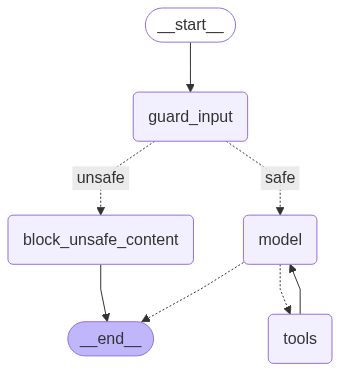

In [9]:
from IPython.display import Image, display

Image(research_assistant.get_graph().draw_mermaid_png())

In [ ]:
config = {"configurable": {"thread_id": "123"}}
await research_assistant.ainvoke(
    {
        "messages": (
            "user",
            "nigga",
        )
    },
    config,
)

{'messages': [HumanMessage(content='nigga', additional_kwargs={}, response_metadata={}, id='3cbfa081-f337-44e3-9dc2-1a2b08fe6a95'),
  HumanMessage(content='nigga', additional_kwargs={}, response_metadata={}, id='136afd76-b446-479c-b311-288b3e473a66'),
  AIMessage(content='I cannot respond to queries that contain offensive or inappropriate language. Please use respectful language in your requests.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e4ced491-2a8e-4baa-acbb-26ef86f063ef-0', usage_metadata={'input_tokens': 232, 'output_tokens': 20, 'total_tokens': 306, 'input_token_details': {'cache_read': 0}})],
 'safety': LlamaGuardOutput(safety_assessment=<SafetyAssessment.SAFE: 'safe'>, unsafe_categories=[])}